In [1]:
import sys

print("Python:", sys.version)
print("Executable:", sys.executable)

python_exec = sys.executable

!{python_exec} -m pip install --user ultralytics opencv-python "tensorflow<2.16" scikit-learn

Python: 3.10.9 (main, Mar  1 2023, 18:23:06) [GCC 11.2.0]
Executable: /opt/anaconda3/bin/python3
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf

from ultralytics import YOLO
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import preprocess_input

print("TF vrsion:", tf.__version__)

2025-12-09 13:41:25.835027: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-09 13:41:25.865982: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-09 13:41:25.866000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-09 13:41:25.866735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-09 13:41:25.871551: I tensorflow/core/platform/cpu_feature_guar

TF vrsion: 2.15.1


In [3]:
yolo_weights = "/VOL_D/asim.n/runs/train/yolo11n_custom/weights/best.pt"

xception_model_path = "/VOL_D/asim.n/xception_xray_project/xception_full_dataset.h5"

input_images_dir = "/VOL_D/teresa.w/Dataset_YOLO/dataset/images/val"

output_images_dir = "/VOL_D/asim.n/yolo_xception_outputs"
os.makedirs(output_images_dir, exist_ok = True)

In [4]:
material_classes = ["Thermoformed", "Injection moulded", "Foil extrusion"]

XCEPTION_CONF_THRESHOLD = 0.6

YOLO_CONF_THRESHOLD = 0.5
MAX_BOX_REL_AREA = 0.5

XCEPTION_IMG_SIZE = (299, 299)

print("YOLO Weights exists?     ", os.path.isfile(yolo_weights))
print("Xception model exists?   ", os.path.isfile(xception_model_path))
print("Input images dir exists? ", os.path.isdir(input_images_dir))

YOLO Weights exists?      True
Xception model exists?    True
Input images dir exists?  True


In [5]:
import os
print(os.path.isfile("/VOL_D/asim.n/runs/train/yolo11n_custom/weights/best.pt"))

True


In [6]:
import os
input_images_dir = "/VOL_D/teresa.w/Dataset_YOLO/dataset/images/val"

print(os.path.isdir(input_images_dir))
print(os.listdir(input_images_dir)[:5])

True
['.ipynb_checkpoints', 'task-11929-yolo_250415.png', 'task-100-tobi.png', 'task-101-tobi.png', 'task-11826.png']


In [7]:
print(" Loading YOLO model...")
yolo_model = YOLO(yolo_weights)

print( " Loading Xception model...")
xception_model = load_model(xception_model_path)

print(" Models loaded ")

 Loading YOLO model...
 Loading Xception model...


2025-12-09 13:41:28.340120: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


 Models loaded 


In [16]:
def classify_patch_with_xception(patch_bgr):
    """
    patch_bgr: cropped patch from OpenCV image in BGR format.
    returns: (predicted_label, confidence)
    
    """
    patch_rgb = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2RGB)
    patch_resized = cv2.resize(patch_rgb, XCEPTION_IMG_SIZE)

    x = patch_resized.astype("float32")
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = xception_model.predict(x, verbose= 0)[0]
    class_idx = int(np.argmax(preds))
    conf = float(preds[class_idx])

    if conf < XCEPTION_CONF_THRESHOLD:
        label = "Unknown"
    else:
        label = material_classes[class_idx]

    return label, conf

def run_yolo_xception_on_image(image_path,
                               save_output=True,
                               show_debug_info=True):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read {image_path}")
        return None

    h, w = img.shape[:2]
    if show_debug_info:
        print(f" Processing {os.path.basename(image_path)} (H={h}, W={w}")

    results = yolo_model(img, conf=YOLO_CONF_THRESHOLD)[0]

    if results.boxes is None or len(results.boxes) == 0:
        if show_debug_info:
            print("No detections found.")
        if save_output:
            basename = os.path.basename(image_path)
            out_path = os.path.join(output_images_dir, basename)
            cv2.imwrite(out_path, img)
        return []

    boxes = results.boxes.xyxy.cpu().numpy().astype(int)
    scores = results.boxes.conf.cpu().numpy()
    yolo_classes = results.boxes.cls.cpu().numpy().astype(int)

    detections =[]
    img_area = w*h

    for i, box in enumerate(boxes):
        x1,y1, x2, y2 = box
        score = float(scores[i])
        cls_id = int(yolo_classes[i])

        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(w - 1, x2)
        y2 = min(h - 1, y2)

        bw = x2 - x1
        bh = y2 - y1
        if bw <= 0 or bh <= 0:
            continue

        box_area = bw * bh

        if box_area > MAX_BOX_REL_AREA * img_area:
            if show_debug_info:
                print(f" - Skipping big box {box} (area ratio {box_area/img_area:.2f}")
            continue

        patch = img[y1:y2, x1:x2]
        if patch.size == 0:
            continue

        material_label, material_conf = classify_patch_with_xception(patch)
        detections.append({
            "bbox": [int(x1), int(y1), int(x2), int(y2)],
            "yolo_conf": score,
            "yolo_cls": cls_id,
            "material_label": material_label,
            "material_conf": material_conf
        })

        color = (0, 255, 0) if material_label != "Unknown" else (0, 0, 255)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        text = f"{material_label} {material_conf:.2f}"
        y_text = max(0, y1 -10)
        cv2.putText(img, text, (x1, y_text),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, color, 2)

    if save_output:
        basename = os.path.basename(image_path)
        out_path = os.path.join(output_images_dir, basename)
        cv2.imwrite(out_path, img)
        if show_debug_info:
            print("Saved:", out_path)

    return detections

        

In [17]:
all_results = {}

for fname in sorted(os.listdir(input_images_dir)):
    if not fname.lower().endswith((".jpg",".jpeg",".png")):
        continue
    img_path = os.path.join(input_images_dir, fname)
    detections = run_yolo_xception_on_image(img_path)
    all_results[fname] = detections

print("\n Done. Processed", len(all_results), "images.")

 Processing task-100-tobi.png (H=3032, W=5320

0: 384x640 1 TF, 4 IMs, 6.1ms
Speed: 2.1ms preprocess, 6.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Saved: /VOL_D/asim.n/yolo_xception_outputs/task-100-tobi.png
 Processing task-101-tobi.png (H=3032, W=5320

0: 384x640 2 TFs, 2 IMs, 1 FE, 4.4ms
Speed: 1.7ms preprocess, 4.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Saved: /VOL_D/asim.n/yolo_xception_outputs/task-101-tobi.png
 Processing task-103-smart_factory.png (H=3032, W=5320

0: 384x640 2 TFs, 2 IMs, 1 FE, 4.4ms
Speed: 1.7ms preprocess, 4.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Saved: /VOL_D/asim.n/yolo_xception_outputs/task-103-smart_factory.png
 Processing task-104-smart_factory.png (H=3032, W=5320

0: 384x640 1 IM, 1 FE, 4.8ms
Speed: 1.7ms preprocess, 4.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Saved: /VOL_D/asim.n/yolo_xception_outputs/task-104-smart_factory.png
 Processing tas

Showing: task-100-tobi.png


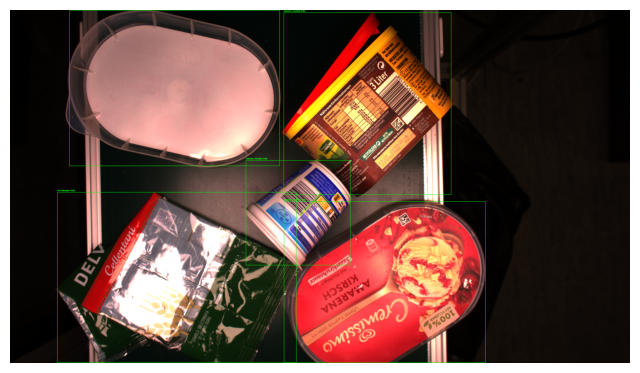

Detection: [{'bbox': [2351, 1648, 4079, 3028], 'yolo_conf': 0.9742652773857117, 'yolo_cls': 1, 'material_label': 'Injection moulded', 'material_conf': 0.9964529275894165}, {'bbox': [509, 12, 2313, 1343], 'yolo_conf': 0.9698137640953064, 'yolo_cls': 1, 'material_label': 'Injection moulded', 'material_conf': 0.9983982443809509}, {'bbox': [2349, 31, 3785, 1590], 'yolo_conf': 0.9697438478469849, 'yolo_cls': 1, 'material_label': 'Injection moulded', 'material_conf': 0.8007347583770752}, {'bbox': [2024, 1296, 2919, 2193], 'yolo_conf': 0.9494491219520569, 'yolo_cls': 0, 'material_label': 'Injection moulded', 'material_conf': 0.8043529987335205}, {'bbox': [406, 1569, 2456, 3026], 'yolo_conf': 0.935143232345581, 'yolo_cls': 1, 'material_label': 'Foil extrusion', 'material_conf': 0.9898776412010193}]


In [19]:
import matplotlib.pyplot as plt

if all_results:
    sample_name = sorted(all_results.keys())[0]
    print("Showing:", sample_name)

    out_path = os.path.join(output_images_dir, sample_name)
    img_bgr = cv2.imread(out_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

    print("Detection:", all_results[sample_name])
else:
    print("No images processed.")